In this notebook, we will implement a random forest in Python. With machine learning in Python, it's very easy to build a complex model without having any idea how it works. Therefore, we'll start with a single decision tree and a simple problem, and then work our way to a random forest and a real-world problem.

Once we understand how a single decision tree thinks, we can transfer this knowledge to an entire forest of trees.
The problem we’ll solve is a binary classification task with the goal of predicting an individual’s health. The features are socioeconomic and lifestyle characteristics of individuals and the label is 0 for poor health and 1 for good health. This dataset was collected by the Centers for Disease Control and Prevention 

https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/behavioral-risk-factor-surveillance-system/2011.csv
/kaggle/input/behavioral-risk-factor-surveillance-system/2013.csv
/kaggle/input/behavioral-risk-factor-surveillance-system/2015.csv
/kaggle/input/behavioral-risk-factor-surveillance-system/2014.csv
/kaggle/input/behavioral-risk-factor-surveillance-system/2012.csv
/kaggle/input/behavioral-risk-factor-surveillance-system/2015_formats.json


In [2]:

df = pd.read_csv('../input/behavioral-risk-factor-surveillance-system/2015.csv').sample(10000, random_state = 50)
df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
383119,49.0,4.0,b'05192015',b'05',b'19',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
55536,9.0,9.0,b'09232015',b'09',b'23',b'2015',1100.0,2.015005e+09,2.015005e+09,1.0,...,2.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
267093,34.0,10.0,b'11052015',b'11',b'05',b'2015',1100.0,2.015011e+09,2.015011e+09,NaN,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
319092,41.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,2.0
420978,54.0,5.0,b'05112015',b'05',b'11',b'2015',1100.0,2.015004e+09,2.015004e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0


In [3]:
df['_RFHLTH'].value_counts()

1.0    8111
2.0    1869
9.0      20
Name: _RFHLTH, dtype: int64

In [4]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})

In [5]:
df['_RFHLTH'].value_counts()

1.0    8111
0.0    1869
9.0      20
Name: _RFHLTH, dtype: int64

In [6]:
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()

In [7]:
df['_RFHLTH'].value_counts()

1.0    8111
0.0    1869
Name: _RFHLTH, dtype: int64

In [8]:
df = df.rename(columns = {'_RFHLTH': 'Label'})

We won't do any data exploration in this notebook, but in general, exploring the data is a best practice. This can help you for feature engineering (which we also won't do here) or by identifying and correcting anomalies / mistakes in the data.

In [9]:
df.shape

(9980, 330)

In [10]:
percentOfData = df.count()*100/9980

In [11]:
percentOfData.where(percentOfData<50).dropna()

COLGHOUS     0.000000
LADULT       0.000000
CTELNUM1    42.174349
CELLFON2    42.174349
CADULT      42.174349
              ...    
_CLLCPWT    13.466934
PADUR2_     44.458918
PAFREQ2_    44.959920
_FLSHOT6    36.122244
_PNEUMO2    36.122244
Length: 150, dtype: float64

In [12]:
badFeatures = percentOfData.where(percentOfData<50).dropna()

In [13]:
# Remove columns with missing values
df = df.drop(columns = badFeatures.index.to_list())

In [14]:
# Remove all non float data
df = df.select_dtypes(include=['float64'])

In [15]:
#Removing few more columns
df = df.drop(columns=['SEX','_STATE','FMONTH','SEQNO','DISPCODE','MARITAL','EDUCA','POORHLTH', 'PHYSHLTH', 'GENHLTH', 'HLTHPLN1', 'MENTHLTH'])

In [16]:
from IPython.display import HTML
HTML(pd.DataFrame(df.dtypes).to_html())

,0
_PSU,float64
CTELENUM,float64
PVTRESD1,float64
STATERES,float64
CELLFON3,float64
NUMADULT,float64
NUMMEN,float64
NUMWOMEN,float64
PERSDOC2,float64
MEDCOST,float64


In [17]:
df.head()

,_PSU,CTELENUM,PVTRESD1,STATERES,CELLFON3,NUMADULT,NUMMEN,NUMWOMEN,PERSDOC2,MEDCOST,...,_PA30021,_PASTRNG,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_AIDTST3
383119,2.015009e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,2.0,2.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
55536,2.015005e+09,1.0,1.0,1.0,1.0,2.0,1.000000e+00,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
267093,2.015011e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,2.0,2.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
319092,2.015002e+09,1.0,1.0,1.0,1.0,1.0,5.397605e-79,1.0,1.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0
420978,2.015004e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,...,2.0,1.0,1.0,1.0,3.0,3.0,4.0,1.0,1.0,2.0


In [19]:
from sklearn.model_selection import train_test_split

# Extract the labels
#labels = np.array(df.pop('Label'))

# 30% examples in test data
train, test, train_labels, test_labels = train_test_split(df, df['Label'], test_size = 0.3, 
                                                          random_state = 50)

In [20]:
# Imputation of missing values
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [21]:
train.columns

Index(['_PSU', 'CTELENUM', 'PVTRESD1', 'STATERES', 'CELLFON3', 'NUMADULT',
       'NUMMEN', 'NUMWOMEN', 'PERSDOC2', 'MEDCOST',
       ...
       '_PA30021', '_PASTRNG', '_PAREC1', '_PASTAE1', '_LMTACT1', '_LMTWRK1',
       '_LMTSCL1', '_RFSEAT2', '_RFSEAT3', '_AIDTST3'],
      dtype='object', length=161)

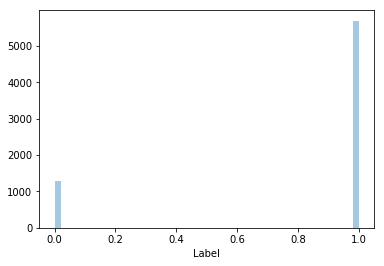

In [22]:
sns.distplot(train['Label'], kde=False)

In [23]:
train.shape

(6986, 161)

In [24]:
test.shape

(2994, 161)

In [25]:
# Train tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=50, max_depth=60)
tree.fit(train, train_labels)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 3 nodes with maximum depth 1.


In [26]:
# Make probability predictions
train_probs = tree.predict_proba(train)[:, 1]
probs = tree.predict_proba(test)[:, 1]

train_predictions = tree.predict(train)
predictions = tree.predict(test)

In [27]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 1.0


In [28]:
print(f'Baseline ROC AUC: {roc_auc_score(test_labels, [1 for _ in range(len(test_labels))])}')

Baseline ROC AUC: 0.5


Our model does outperform a baseline guess, but we can see it has severely overfit to the training data, acheiving perfect ROC AUC.

In [31]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

TODO: construct ROC curve and confusion matrix

In [32]:
from collections import Counter
print(Counter(probs))
print(Counter(predictions))

Counter({1.0: 2418, 0.0: 576})
Counter({1.0: 2418, 0.0: 576})


Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.81 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


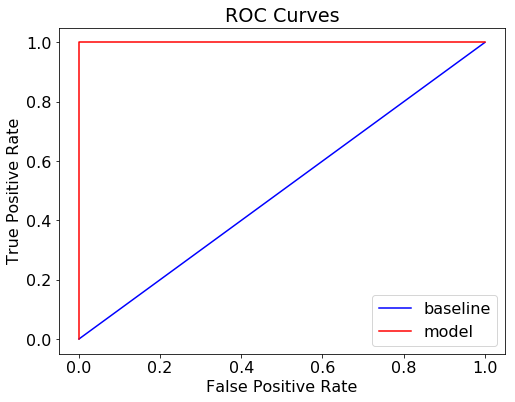

In [33]:
evaluate_model(predictions, probs, train_predictions, train_probs)

In [34]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 576    0]
 [   0 2418]]


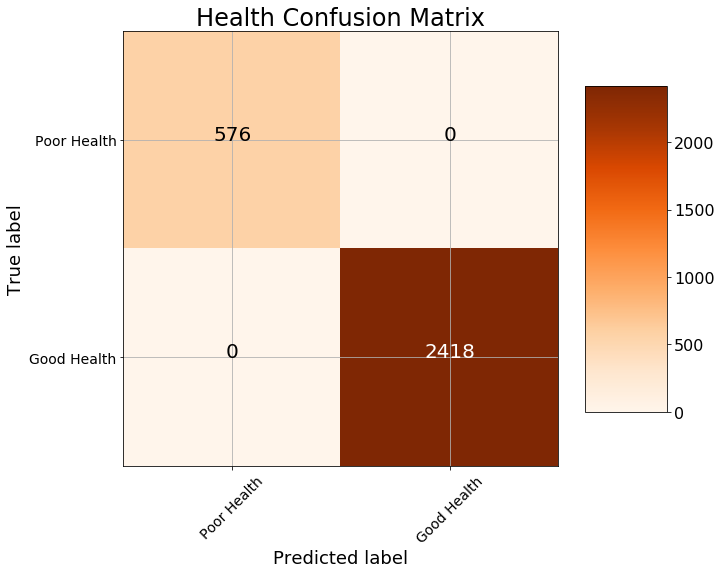

In [35]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

In [38]:
features = list(train.columns)
fi = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi.head()

,feature,importance
73,Label,1.0
0,_PSU,0.0
110,FTJUDA1_,0.0
103,_SMOKER3,0.0
104,_RFSMOK3,0.0


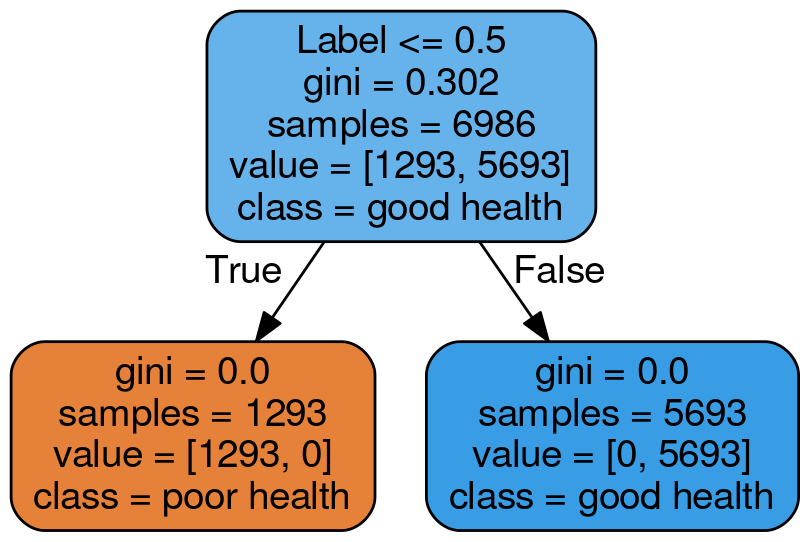

In [42]:
# Save tree as dot file
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image
export_graphviz(tree, 'tree_real_data.dot', rounded = True, 
                feature_names = features, max_depth = 6,
                class_names = ['poor health', 'good health'], filled = True)

# Convert to png
call(['dot', '-Tpng', 'tree_real_data.dot', '-o', 'tree_real_data.png', '-Gdpi=200'])

# Visualize
Image(filename='tree_real_data.png')

In [45]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=50, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)
#RSEED = 50
# Fit on training data
model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [46]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 628
Average maximum depth 19


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Baseline: 1.0 Test: 1.0 Train: 1.0
Precision Baseline: 0.81 Test: 1.0 Train: 1.0
Roc Baseline: 0.5 Test: 1.0 Train: 1.0


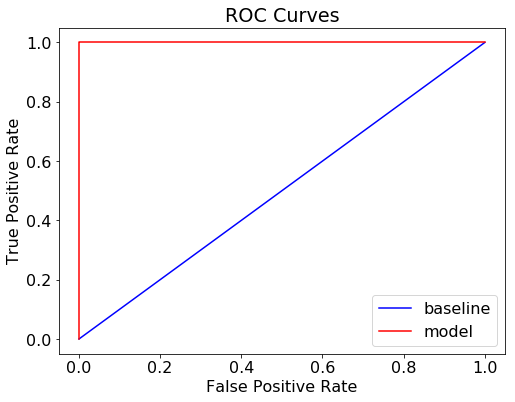

In [49]:
#Random Forest Results
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

Confusion matrix, without normalization
[[ 576    0]
 [   0 2418]]


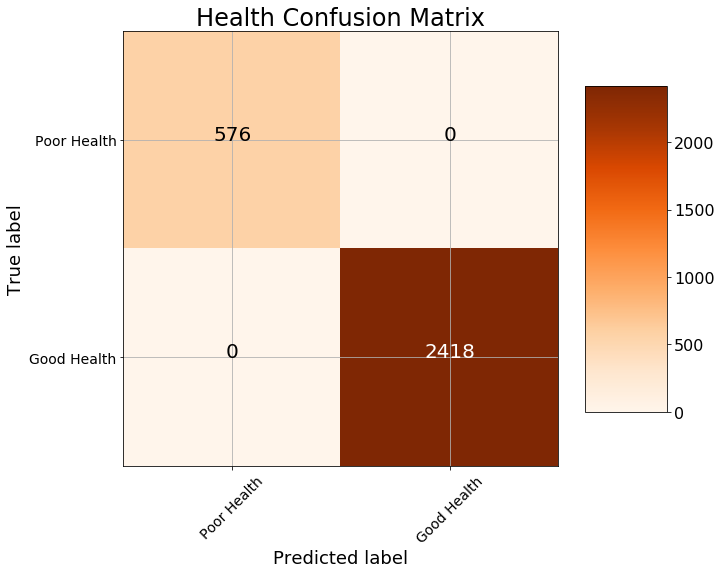

In [50]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix')

In [51]:
fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi_model.head(10)

,feature,importance
73,Label,0.449614
40,DIFFWALK,0.040656
36,QLACTLM2,0.022877
37,USEEQUIP,0.019322
30,EMPLOY1,0.015639
21,CHCCOPD1,0.012051
42,DIFFALON,0.010329
157,_LMTSCL1,0.009967
39,DECIDE,0.009727
25,DIABETE3,0.009558


In [53]:
#Conclusions
#In this notebook, we built and used a random forest machine learning model in Python. Rather than just writing the code and not understanding the model, we formed an understanding of the random forest by inspecting an individual decision tree and discussion its limitations. We visualized the decision tree to see how it makes decisions and also saw how one decision tree overfits to the trainig data. To overcome the limitations of a single decision tree, we can train hundreds or thousands of them in a single ensemble model. This model, known as a random forest, trains each tree on a different set of the training observations, and make splits at each node based on a subset of the features leading to a model with reduced variance and better generalization performance on the testing set.

#A few key concepts to take away are

#Individual decision tree: intuitive model that makes decisions based on a flowchart of questions asked about feature values. Has high variance indicated by overfitting to the training data.
#Gini Impurity: Measure that the decision tree tries to minimize when splitting each node. Represents the probability that a randomly selected sample from a node will be incorreclty classified according to the distribution of samples in the node.
#Bootstrapping: sampling random sets of observations with replacement. Method used by the random forest for training each decision tree.
#Random subsets of features: selecting a random set of the features when considering how to split each node in a decision tree.
#Random Forest: ensemble model made of hundreds or thousands of decision trees using bootstrapping, random subsets of features, and average voting to make predictions.
#Bias-variance tradeoff: the fundamental issue in machine learning that describes the tradeoff between a model with high complexity that learns the training data very well at the cost of not being able to generalize to the testing data (high variance), and a simple model (high bias) that cannot even learn the training data. A random forest reduces the variance of a single decision tree while also accurately learning the training data leading to better predictions on the testing data.
#Hopefully this notebook has given you not only the code required to use a random forest, but also the background necessary to understand how the model is making decisions. Machine learning is a powerful tool and it's important to not only know how to use the tool, but also to understand how it works!